In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import cmcrameri.cm as cm

from tqdm import tqdm
from utils import ELFData, ELFModel

## Load and filter data

In [2]:
# Load data
unlabeled = ELFData()
unlabeled.load_processed(dirname='data/unlabeled', structure=False)
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Parse profiles: 100%|██████████| 320585/320585 [00:18<00:00, 16969.99it/s]      


Number of examples: 320585


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,4,3.812422,1.2,16,K,Cl,False,0
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,5,3.812422,1.2,16,K,Cl,False,0
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,6,3.812422,1.2,16,K,Cl,False,0
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,7,3.812422,1.2,16,K,Cl,False,0
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,8,3.812422,1.2,16,K,Cl,False,0


In [3]:
# Sort and filter data
unlabeled.data = unlabeled.data[~unlabeled.data['mixed']].reset_index(drop=True)
unlabeled.get_pdf_cdf()
unlabeled.sort_by_cdf()
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Number of examples: 279511


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.20362998371703642, 0.28...","[0.014509947675761763, 0.017329271852047815, 0...","[0.014509947675761763, 0.031839219527809576, 0..."
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.22271259596505436, 0.18323072767531332, 0.1...","[0.018490642709179408, 0.015212673105021801, 0...","[0.018490642709179408, 0.03370331581420121, 0...."
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.2227125959650543, 0.18323072767531332, 0.19...","[0.0184906427091794, 0.015212673105021801, 0.0...","[0.0184906427091794, 0.033703315814201204, 0.0..."


### Calculate columns

In [4]:
unlabeled.data['pdf-l_srt'] = unlabeled.data[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)

unlabeled.data['cdf-A_srt'] = unlabeled.data[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)

## Predict data classes

In [5]:
n_classes = 3
n_components = 10
columns = ['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt']
features = ['l', 'A']
n_estimators = 150
max_depth = 12

### Load models

In [6]:
savedir = 'models/'
models = []
for column in columns:
    path = '_'.join([j + str(k) for (j,k) in zip(['c', 'z', 'n', 'd'],
                     [n_classes, n_components, n_estimators, max_depth])] + [column] + features)
    models.append(ELFModel(n_classes))
    models[-1].load_model(savedir + path)

### Predict

In [7]:
for i in tqdm(range(len(columns)), bar_format=unlabeled.bar_format):
    models[i].prepare_inputs(unlabeled.data)
    unlabeled.data = models[i].clf_predict(unlabeled.data)

100%|██████████| 5/5 [00:44<00:00,  8.99s/it]                                   


In [8]:
unlabeled.data.head()

,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,pdf_srt_pred,z_pdf-l_srt,pdf-l_srt_pred_proba,pdf-l_srt_pred,z_cdf_srt,cdf_srt_pred_proba,cdf_srt_pred,z_cdf-A_srt,cdf-A_srt_pred_proba,cdf-A_srt_pred
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,2,"[-1.4945753043948937, -0.7040184601888102, -0....","[0.02666666666666667, 0.0, 0.9733333333333334]",2,"[0.5477923213645963, 0.17560694250467607, -0.1...","[0.03333333333333333, 0.0, 0.9666666666666667]",2,"[-11.679129332372147, 5.348374937186667, 0.086...","[0.03372115953460856, 0.0, 0.9662788404653914]",2
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,2,"[-1.4945753043948937, -0.7040184601888103, -0....","[0.02666666666666667, 0.0, 0.9733333333333334]",2,"[0.5477923213645963, 0.17560694250467607, -0.1...","[0.03333333333333333, 0.0, 0.9666666666666667]",2,"[-11.679129332372147, 5.348374937186667, 0.086...","[0.03372115953460856, 0.0, 0.9662788404653914]",2
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,2,"[-1.3964580609093797, -0.6400228232544939, -0....","[0.06819121447028423, 0.006666666666666667, 0....",2,"[0.4277850266199073, 0.039773129189330576, -0....","[0.08666666666666667, 0.0, 0.9133333333333333]",2,"[-11.538736624581158, 4.111602767696473, -1.25...","[0.04019972241968789, 0.0, 0.9598002775803122]",2
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,2,"[-1.4945753043948937, -0.7040184601888103, -0....","[0.02666666666666667, 0.0, 0.9733333333333334]",2,"[0.5477923213645963, 0.17560694250467607, -0.1...","[0.03333333333333333, 0.0, 0.9666666666666667]",2,"[-11.679129332372147, 5.348374937186667, 0.086...","[0.03372115953460856, 0.0, 0.9662788404653914]",2
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,2,"[-1.39645806090938, -0.6400228232544939, -0.77...","[0.06819121447028423, 0.006666666666666667, 0....",2,"[0.4277850266199073, 0.039773129189330576, -0....","[0.08666666666666667, 0.0, 0.9133333333333333]",2,"[-11.538736624581158, 4.111602767696473, -1.25...","[0.04019972241968789, 0.0, 0.9598002775803122]",2


In [9]:
n_bins = 10
_, bins = np.histogram(unlabeled.data['l'], bins=n_bins)
unlabeled.data['l_bin'] = np.digitize(unlabeled.data['l'], bins[:-1], right=False).tolist()

_, bins = np.histogram(unlabeled.data['A'], bins=n_bins)
unlabeled.data['A_bin'] = np.digitize(unlabeled.data['A'], bins[:-1], right=False).tolist()

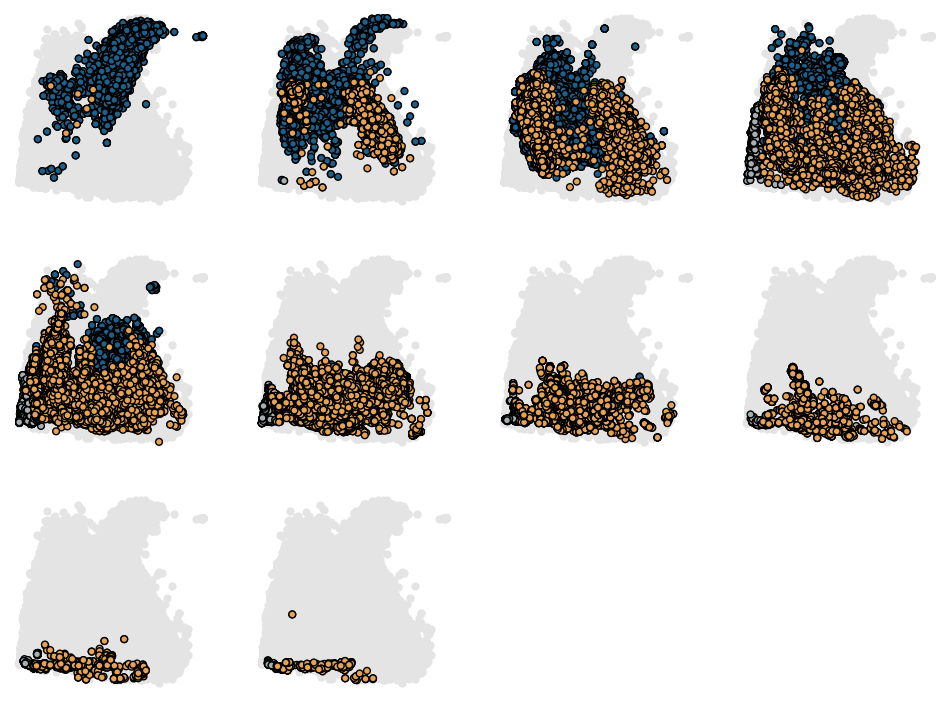

In [10]:
i = 0
x = [np.stack(unlabeled.data.loc[unlabeled.data['l_bin']==k, 'z_' + columns[i]].values) for k in range(1,n_bins+1)]
y = [unlabeled.data.loc[unlabeled.data['l_bin']==k, columns[i] + '_pred'].values for k in range(1,n_bins+1)]
fig = models[i].plot_projection_slices(x=x, y=y, axes=[0,1], cmap=models[i].dmap, order=True)

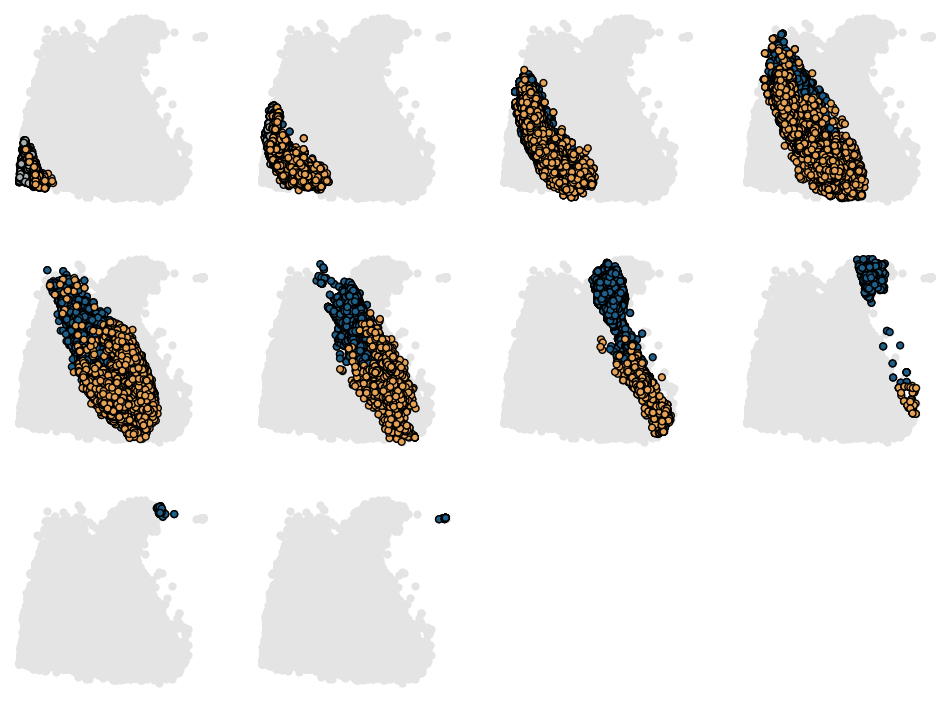

In [11]:
x = [np.stack(unlabeled.data.loc[unlabeled.data['A_bin']==k, 'z_' + columns[i]].values) for k in range(1,n_bins+1)]
y = [unlabeled.data.loc[unlabeled.data['A_bin']==k, columns[i] + '_pred'].values for k in range(1,n_bins+1)]
fig = models[i].plot_projection_slices(x=x, y=y, axes=[0,1], cmap=models[i].dmap, order=True)

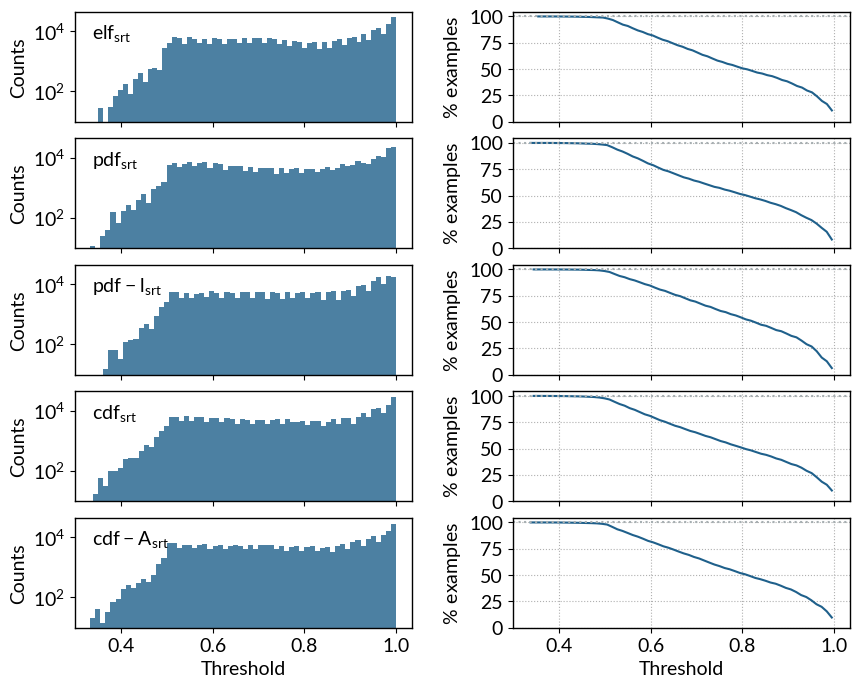

In [63]:
bins = 60
fig, ax = plt.subplots(len(columns), 2, figsize=(10,8), sharex=True, sharey='col')
fig.subplots_adjust(wspace=0.3, hspace=0.15)
for i, column in enumerate(columns):
    y, x, _ = ax[i,0].hist(unlabeled.data[column + '_pred_proba'].apply(max), bins=bins, log=True,
                           color=unlabeled.palette[0], alpha=0.8)
    ax[i,0].text(0.05, 0.9, r'$' + '_{'.join(column.split('_')) + '}$', ha='left', va='top',
                 transform=ax[i,0].transAxes)
    ax[i,1].plot(0.5*(x[:-1][::-1] + x[1:][::-1]), 100*y[::-1].cumsum()/len(unlabeled.data),
                 color=unlabeled.palette[0])
    ax[i,1].axhline(100, color=unlabeled.palette[1], ls=':')
    ax[i,1].set_ylim(bottom=0)
    ax[i,1].locator_params(axis='y', nbins=5)
    ax[i,1].grid(visible=True, ls=':')
    
    ax[i,0].set_ylabel('Counts')
    ax[i,1].set_ylabel(r'$\%\ examples$')

ax[-1,0].set_xlabel('Threshold')
ax[-1,1].set_xlabel('Threshold');